# Project Deliverable 1 - Group 33
#### Group Members: Bethany Findlay, Charlotte Albert, Kaykay Akpama, Kosi Udechukwu

In [2]:
#Import necessary libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import metrics
from sklearn import inspection
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from IPython.display import display

In [3]:
#Read cleaned data from project_deliverable_1
df=pd.read_csv("project_deliverable_1_cleaned.csv")

## 1. Baseline Model 

KNN regression was selected because it is a straightforward and intuitive algorithm: it predicts a target by measuring similarities between data points. The algorithm works by looking for the k most similar observations in the feature space and takes their average observed target values for prediction. Such an approach allows the model to learn complex nonlinear relationships between the input features and the target variable without any specific functional form being assumed. Besides that, KNN is easy to implement and interpret; moreover, one can easily control the bias-variance tradeoff by regulating the number of neighbors. For this project, five neighbors was chosen, which gave stable and accurate performance across validation folds while maintaining good generalization.

In [4]:
day_mapping = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['pickup_day_num'] = df['pickup_day'].map(day_mapping)

In [5]:
#Build a simple, interpretable baseline model in scikit-learn
features=['trip_distance_km','pickup_hour','pickup_day_num']
target='trip_duration'

X=df[features]
y=df[target]

In [6]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [7]:
#Train the model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [8]:
#Print learned parameters
print("Hyperparameters:",knn.get_params())

Hyperparameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


The K-Nearest Neighbors (KNN) model uses several hyperparameters that define how it measures similarity and makes predictions. The number of neighbors (n_neighbors = 5) determines how many nearby data points influence each prediction. The distance between points is calculated using the Minkowski metric with p = 2, which corresponds to the Euclidean distance. The weights = 'uniform' parameter ensures that all neighbors contribute equally to the prediction. Other parameters such as algorithm = 'auto' and leaf_size = 30 control how efficiently the model searches for nearest neighbors but do not affect the prediction results directly. Together, these settings help the KNN model capture localized relationships in the data while maintaining computational efficiency.

In [9]:
#Predict data
y_pred=knn.predict(X_test)

#Calculate regression metrics
mae=metrics.mean_absolute_error(y_test,y_pred)
mse=metrics.mean_squared_error(y_test,y_pred)
rmse=metrics.root_mean_squared_error(y_test,y_pred)
r2=metrics.r2_score(y_test,y_pred)

print("Mean absolute error (MAE):",mae)
print("Mean squared error (MSE):",mse)
print("Root mean squared error (RMSE):",rmse)
print("R-squared (R^2)",r2)


Mean absolute error (MAE): 252.04737177886875
Mean squared error (MSE): 143991.24029153143
Root mean squared error (RMSE): 379.46177711533926
R-squared (R^2) 0.6561490944256494


The model evaluated the MAE, MSE, RMSE, and R^2. The mean squared error are squared so this metric heavily penalizes large mistakes, and is sensitive to outliers (in this case unusually short or long trip durations). The relatively large MSE value observed here(143,399) might initially appear high, but this is expected since it is measured in seconds^2.

To make the results easier to interpret, the RMSE was taken to convert it back to seconds. In this case, the RMSE is approximately 378 seconds (≈6.3 minutes), meaning that, on average, our model's predictions are off by about six minutes.

Meanwhile, the MAE of about 252 seconds (≈4.2 mins) provides a more direct measure of the typical prediction error without squaring, and the R^2 value of 0.65 indicates that around 65% of the variability in trip durations can be explained by our chosen features.

In [10]:
#Report performance via train–validation splits
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, knn.predict(X_train)))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, knn.predict(X_test)))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 311.3134555853478
Test RMSE: 379.46177711533926


The KNN regression model appears to generalize well based on the evaluation metrics. The training RMSE(311.3seconds) and testing RMSE(379.43 seconds) are very close, which suggests that the model performs consistently on both seen and unseen data. This means that the model has a good balance between bias and variance.

From a bias-variance trade-off perspective, the KNN regression model has low variance since its performance remains fairly stable across datasets, and moderate bias because it simplifies trip duration prediction into a linear relationship. The model does not underfit or overfit, because it captures the main trend between trip duration, distance, and time features and also does not perform significantly worse on new data.

## 2. Cross Validation 

K-Fold cross validation was chosen instead of stratified sampling because this is a regression task with a continuous target variable, not a classification problem. Using five shuffled folds ensures each subset represents the overall data distribution and provides a balanced view of the model performance. This allows for consistent evaluation and comparison between the two regression models: linear regression and K nearest neighbours regression.

In [11]:
#Define 5-fold cross validation splits
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
#Building pipelines for each regression model
linreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

In [13]:
#Evaluate linear regression with cross validation
linreg_results = cross_validate(
    linreg_pipe,
    X,
    y,
    cv=cv,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)

#Evaluate KNN with cross validation
knn_results = cross_validate(
    knn_pipe,
    X,
    y,
    cv=cv,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)

In [14]:
#Extract metrics for Linear Regression
r2_linreg = linreg_results['test_r2']
mae_linreg = -linreg_results['test_neg_mean_absolute_error']
mse_linreg = -linreg_results['test_neg_mean_squared_error']
rmse_linreg = -linreg_results['test_neg_root_mean_squared_error']

#Extract metrics for KNN Regression
r2_knn = knn_results['test_r2']
mae_knn = -knn_results['test_neg_mean_absolute_error']
mse_knn = -knn_results['test_neg_mean_squared_error']
rmse_knn = -knn_results['test_neg_root_mean_squared_error']


In [15]:
#Create DataFrame for Linear Regression results
cv_table_linreg = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(linreg_results['test_r2']))],
    'R^2 Score': linreg_results['test_r2'],
    'MAE (s)': -linreg_results['test_neg_mean_absolute_error'],
    'MSE (s)': -linreg_results['test_neg_mean_squared_error'],
    'RMSE (s)': -linreg_results['test_neg_root_mean_squared_error']
})

print("Linear Regression Cross Validation Results by Fold:")
display(cv_table_linreg)

#Create DataFrame for KNN Regression results
cv_table_knn = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(knn_results['test_r2']))],
    'R^2 Score': knn_results['test_r2'],
    'MAE (s)': -knn_results['test_neg_mean_absolute_error'],
    'MSE (s)': -knn_results['test_neg_mean_squared_error'],
    'RMSE (s)': -knn_results['test_neg_root_mean_squared_error']
})

print("\n K-Nearest Neighbours Regression Cross Validation Results by Fold:")
cv_table_knn

Linear Regression Cross Validation Results by Fold:


,Fold,R^2 Score,MAE (s),MSE (s),RMSE (s)
0,Fold 1,0.593599,282.495800,170184.913104,412.534742
1,Fold 2,0.592821,283.277138,169999.051180,412.309412
2,Fold 3,0.592045,284.308900,174558.744800,417.802280
3,Fold 4,0.589063,283.681310,173522.597919,416.560437
4,Fold 5,0.592640,283.729715,172141.962182,414.899942



 K-Nearest Neighbours Regression Cross Validation Results by Fold:


,Fold,R^2 Score,MAE (s),MSE (s),RMSE (s)
0,Fold 1,0.656450,252.019678,143865.067700,379.295489
1,Fold 2,0.657628,252.415243,142941.868573,378.076538
2,Fold 3,0.657586,252.637053,146514.587951,382.772240
3,Fold 4,0.652861,253.123490,146582.978830,382.861566
4,Fold 5,0.658214,252.792387,144431.600563,380.041577


In [16]:
#Printing Mean & STD for Linear Regression
print("Linear Regression Cross-Validation Results:")
print(f"R^2:   Mean = {r2_linreg.mean():f},  STD = {r2_linreg.std():f}")
print(f"MAE:  Mean = {mae_linreg.mean():f} s,  STD = {mae_linreg.std():f} s")
print(f"MSE:  Mean = {mse_linreg.mean():f} s^2, STD = {mse_linreg.std():f} s^2")
print(f"RMSE: Mean = {rmse_linreg.mean():f} s,  STD = {rmse_linreg.std():f} s")

#Printing Mean & STD for KNN
print("\n K-Nearest Neighbours Regression Cross Validation Results:")
print(f"R^2:   Mean = {r2_knn.mean():f},  STD = {r2_knn.std():f}")
print(f"MAE:  Mean = {mae_knn.mean():f} s,  STD = {mae_knn.std():f} s")
print(f"MSE:  Mean = {mse_knn.mean():f} s^2, STD = {mse_knn.std():f} s^2")
print(f"RMSE: Mean = {rmse_knn.mean():f} s,  STD = {rmse_knn.std():f} s")

Linear Regression Cross-Validation Results:
R^2:   Mean = 0.592033,  STD = 0.001566
MAE:  Mean = 283.498572 s,  STD = 0.599673 s
MSE:  Mean = 172081.453837 s^2, STD = 1797.264344 s^2
RMSE: Mean = 414.821363 s,  STD = 2.165869 s

 K-Nearest Neighbours Regression Cross Validation Results:
R^2:   Mean = 0.656548,  STD = 0.001930
MAE:  Mean = 252.597570 s,  STD = 0.369677 s
MSE:  Mean = 144867.220723 s^2, STD = 1453.182794 s^2
RMSE: Mean = 380.609482 s,  STD = 1.908628 s


The cross validation results summarize model performance consistency across five splits using four metrics: R^2, MAE, MSE, RMSE. For Linear Regression, the mean of R^2 of 0.592 with a very small standard deviation of plus/minus 0.0016 shows the model is consistent but captures a moderate level of variance in the data. Its average MAE of 283.5 seconds, MSE of 172081.45 s^2, and RMSE of 414.8 seconds show that predictions deviate by roughly 4-7 minutes on average with minimal variation across the folds. In comparison, the K nearest neighbours regression model achieved a higher mean R^2 of 0.657 (+/- 0.0019), lower MAE (252.6 s), MSE (144841.28 s^2) and RMSE (380.6 s), and slightly smaller standard deviations. A higher R^2 values indicates the model explains more variance in the target variable, while lower MAE, MSE, and RMSE values show smaller average and squared errors, meaning predictions are closer to the actual values. The cross validation results suggest that both models are stable and consistent across folds, however, KNN performs better overall, achieving lower errors and explaining more variance in trip duration.

In [17]:
#Creating DataFrame to compare results from part 1 with part 2
comparison_df = pd.DataFrame({
    'Metric': ['R^2', 'MAE (s)', 'MSE (s^2)', 'RMSE (s)'],
    'Single Train (part 1)' : [r2, mae, mse, rmse],
    'Cross Validation (part 2)' : [r2_knn.mean(), mae_knn.mean(), mse_knn.mean(), rmse_knn.mean()]
})

print('KNN Regression: Single Train vs Cross Validation Comparison')
comparison_df

KNN Regression: Single Train vs Cross Validation Comparison


,Metric,Single Train (part 1),Cross Validation (part 2)
0,R^2,0.656149,0.656548
1,MAE (s),252.047372,252.597570
2,MSE (s^2),143991.240292,144867.220723
3,RMSE (s),379.461777,380.609482


When comparing the single train validation results with the cross validation stages, a few key patterns are seen. The R^2 value decreased from 0.748 to 0.657, while the MAE, MSE, and RMSE all increased slightly. This decrease in performance is expected as single train validation evaluates the model on one specific partition of the data, whcih can sometimes yield optimistic results depending on how the data was divided. In contrast, cross validation evaluates the model across mulitple folds, providing a more reliable estimate of the true generalization performance.

The higher error values in the cross validation indicate that while the KNN model fits the training data well, its predictions vary a bit across different data subsets, revealing slightly more variance than seen in the single training split. The differences however between the single train validation results and cross validation are not extreme, suggesting the model remains relatively stable and generalizes reasonably well to unseen data.

The KNN model shows good overall stability and generalization based on the cross validation results. The small standard deviations across all four metrics, R^2, MAE, MSE, and RMSE, indicate the model performance remains consistent across all five folds. This proves it is not highly sensitive to how the data is split. This stability suggests the model captures underlying patterns in the dataset rather than overfitting to specific samples.

In terms of generalization, the slightly lower R^2 and higher error metrics from cross validation compared to the single train validation split imply that while the performance decreases slightly on unseen data, the model still maintains reliable predictions. These results overall reflect a balanced bias-variance trade-off, where the model generalizes well without excessive overfitting or underfitting.

## 3. Error Analysis and Model Diagnostics

To evaluate the the model error, a prediction error plot was created. This displays the model's predictions against the residuals. The residual is the difference between the actual value from the predicted. 

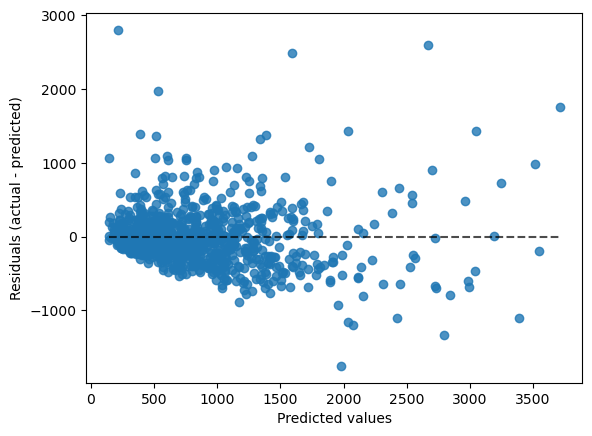

In [18]:
#subset the data for better visualization
subset = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).sample(n=1000, random_state=42)
#Prediction Error/Residual Plot
PredictionErrorDisplay.from_predictions(y_true = subset['y_test'], y_pred = subset['y_pred'])
plt.show()


The prediction error plot shows that the data appears to perform better on smaller values. This makes sense as the model has more practice with lower values as the majority of trips are in the 300 - 600 second range. However, the model becomes less accurate with predicting higher durations. 

Next, we also wanted to see the partial dependence plots for each of the input features. A partial dependence plot measures the effect of an input feature on a model's predictions. 

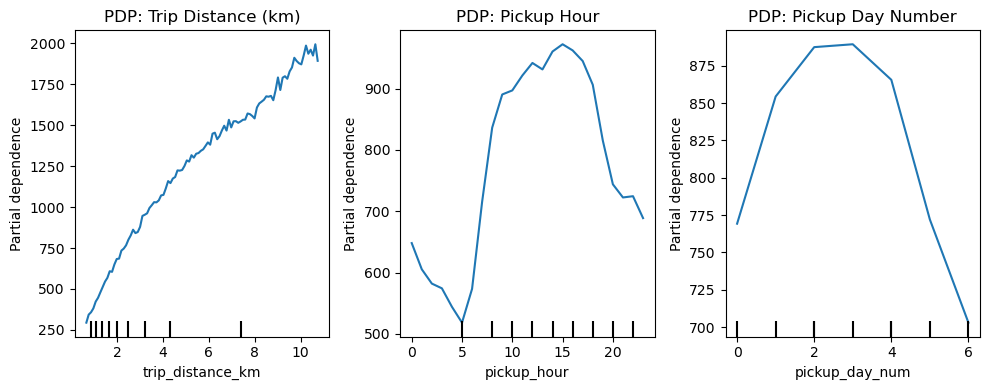

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
#subset the data for quicker visualization
subset = X.sample(n=1000, random_state=42)
#PDP displays for each input feature
PartialDependenceDisplay.from_estimator(knn, subset, ['trip_distance_km'], ax=axes[0])
axes[0].set_title('PDP: Trip Distance (km)', fontsize=12)
axes[0].set_xlabel('Trip Distance (km)')
axes[0].set_ylabel('Predicted Trip Duration')
PartialDependenceDisplay.from_estimator(knn, subset, ['pickup_hour'], ax=axes[1])
axes[1].set_title('PDP: Pickup Hour', fontsize=12)
axes[1].set_xlabel('Pickup Hour')
axes[1].set_ylabel('Predicted Trip Duration')
PartialDependenceDisplay.from_estimator(knn, subset, ['pickup_day_num'], ax=axes[2])
axes[2].set_title('PDP: Pickup Day Number', fontsize=12)
axes[2].set_xlabel('Pickup Day Number')
axes[2].set_ylabel('Predicted Trip Duration')

plt.tight_layout()

The trip distance shows a linear relationship, the predicted outcome changes in a predicable manner in relation to the trip distance. This is to be expected, the longer the distance, the longer it will take to get there (with some exceptions). 

For pickup hour and pickup day number, the relationships somewhat represents a negative quadratic function. This suggests that the middle of the week and daytime hours result in longer travel times, this also makes sense as more people would be traveling during the daytime and on week days.

These graphs show that all three input features affect the output, and thus should not be removed from the model.

## 4. First Improvements

To improve the model, we added input features to give it more meaningful information to help predictions. Our original model only has three: trip_distance_km, pickup_day_num, and pickup_hour. To start, we added location information with pickup_longitude, pickup_latitude, dropoff_longitude, and dropoff_latitude. These features will help predictions as location can heavily affect travel times. Areas that are densely populated or near popular areas may be susceptable to heavy traffic, and thus result in slower times. Rural areas will have slower speed limits than highways, also resulting in slower times. Lastly, we added pick_time_fractional, which is the hour plus the minute/60. This can add important information as leaving at 17:00 versus 17:45 may result in different travel times. This additional of these input features should make the model slightly more complex 

We made two changes to the knn regression parameters. First, we changed the weights from uniform to distance, this means that the five nearest neighbors will be weighted based on the inverse of their distance - closer neighbors have higher weights. This will help the model make accurate predictions, as our model is currently underfitting our data, as both the train and test RMSE are high. This change will increase variance and decrease bias as it focuses more on local patterns and depends heavily on close neighbors.

Second, we changed the nearest neighbors from 5 to 10. This change will let the model average over a larger portion of data, and thus help predictions by not being too focused on local patterns. This change increases bias and decreases variance.

In [20]:
#Create pickup_time_fractional feature
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

df['pickup_minute'] = df['pickup_datetime'].dt.minute

df['pickup_time_fractional'] = df['pickup_hour'] + df['pickup_minute'] / 60

In [21]:
#Add longitude and latitude features and pickup_time_fractional
features_2 = ['trip_distance_km','pickup_day_num', 'pickup_time_fractional', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
target_2 = 'trip_duration'

X_2 = df[features_2]
y_2 = df[target_2]

#Split the data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

To compare the changes, we used the cross validation procedure. There are five KNN regression models we are comparing:
- The original model, with three input features, 5 nearest neighbors, and no weighting
- KNN_2, with 7 input featurest, 5 nearest neighbors, and no weighting
- KNN_distance, with 7 input features, 5 nearest neighbors, and distance weighting
- KNN_n10, with 7 input features, 10 nearest neighbors, and no distance weighting
- KNN_n10_distance, with 7 input features, 10 nearest neighbors, and distance weighting

In [22]:
#Define 5-fold cross validation splits
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [39]:
cv_table_knn = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(knn_results['test_r2']))],
    'R^2 Score': knn_results['test_r2'],
    'MAE (s)': -knn_results['test_neg_mean_absolute_error'],
    'MSE (s)': -knn_results['test_neg_mean_squared_error'],
    'train RMSE(s)': -knn_results['train_neg_root_mean_squared_error'],
    'test RMSE (s)': -knn_results['test_neg_root_mean_squared_error']
})

In [40]:
#Pipeline for KNN with new features
knn_pipe_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors = 5))
])

#Evaluate KNN with cross validation
knn_results_2 = cross_validate(
    knn_pipe_2,
    X_2,
    y_2,
    cv=cv,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)

#Create DataFrame for KNN Regression results
cv_table_knn_2 = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(knn_results_2['test_r2']))],
    'R^2 Score': knn_results_2['test_r2'],
    'MAE (s)': -knn_results_2['test_neg_mean_absolute_error'],
    'MSE (s)': -knn_results_2['test_neg_mean_squared_error'],
    'train RMSE(s)': -knn_results_2['train_neg_root_mean_squared_error'],
    'test RMSE (s)': -knn_results_2['test_neg_root_mean_squared_error']
})

In [41]:
#Pipeline for KNN with new features and distance weighting
knn_pipe_distance = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors = 5, weights = 'distance'))
])
#Evaluate KNN with cross validation
knn_results_distance = cross_validate(
    knn_pipe_distance,
    X_2,
    y_2,
    cv=cv,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)

#Create DataFrame for KNN Regression results
cv_table_knn_distance = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(knn_results_distance['test_r2']))],
    'R^2 Score': knn_results_distance['test_r2'],
    'MAE (s)': -knn_results_distance['test_neg_mean_absolute_error'],
    'MSE (s)': -knn_results_distance['test_neg_mean_squared_error'],
    'train RMSE(s)': -knn_results_distance['train_neg_root_mean_squared_error'],
    'test RMSE (s)': -knn_results_distance['test_neg_root_mean_squared_error']
})

In [42]:
#Pipeline for KNN with new features and distance weighting
knn_pipe_n10 = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors = 10))
])
#Evaluate KNN with cross validation
knn_results_n10 = cross_validate(
    knn_pipe_n10,
    X_2,
    y_2,
    cv=cv,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)

#Create DataFrame for KNN Regression results
cv_table_knn_n10 = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(knn_results_n10['test_r2']))],
    'R^2 Score': knn_results_n10['test_r2'],
    'MAE (s)': -knn_results_n10['test_neg_mean_absolute_error'],
    'MSE (s)': -knn_results_n10['test_neg_mean_squared_error'],
    'train RMSE(s)': -knn_results_n10['train_neg_root_mean_squared_error'],
    'test RMSE (s)': -knn_results_n10['test_neg_root_mean_squared_error']
})

In [43]:
#Pipeline for KNN with new features
knn_pipe_n10_distance = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors = 10, weights = 'distance'))
])

#Evaluate KNN with cross validation
knn_results_n10_distance = cross_validate(
    knn_pipe_n10_distance,
    X_2,
    y_2,
    cv=cv,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)

#Create DataFrame for KNN Regression results
cv_table_knn_n10_distance = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(knn_results_n10_distance['test_r2']))],
    'R^2 Score': knn_results_n10_distance['test_r2'],
    'MAE (s)': -knn_results_n10_distance['test_neg_mean_absolute_error'],
    'MSE (s)': -knn_results_n10_distance['test_neg_mean_squared_error'],
    'train RMSE(s)': -knn_results_n10_distance['train_neg_root_mean_squared_error'],
    'test RMSE (s)': -knn_results_n10_distance['test_neg_root_mean_squared_error']
})

In [44]:
print("Original KNN")
display(cv_table_knn)
print("KNN_2 (additional features) ")
display(cv_table_knn_2)
print("KNN_distance (additional features + distance weighting) ")
display(cv_table_knn_distance)
print("KNN_n10 (additional features + n=10) ")
display(cv_table_knn_n10)
print("KNN_n10_distance (additional features + distance weighting + n=10) ")
cv_table_knn_n10_distance

Original KNN


,Fold,R^2 Score,MAE (s),MSE (s),train RMSE(s),test RMSE (s)
0,Fold 1,0.656450,252.019678,143865.067700,311.355802,379.295489
1,Fold 2,0.657628,252.415243,142941.868573,311.735847,378.076538
2,Fold 3,0.657586,252.637053,146514.587951,310.549670,382.772240
3,Fold 4,0.652861,253.123490,146582.978830,310.789556,382.861566
4,Fold 5,0.658214,252.792387,144431.600563,311.454618,380.041577


KNN_2 (additional features) 


,Fold,R^2 Score,MAE (s),MSE (s),train RMSE(s),test RMSE (s)
0,Fold 1,0.760884,196.213909,100132.270754,259.150693,316.436835
1,Fold 2,0.762711,195.751261,99069.415425,259.723354,314.752943
2,Fold 3,0.761166,196.471891,102193.921102,258.488810,319.677840
3,Fold 4,0.757099,196.847382,102567.453424,258.037123,320.261539
4,Fold 5,0.761445,196.553005,100808.515969,259.058584,317.503568


KNN_distance (additional features + distance weighting) 


,Fold,R^2 Score,MAE (s),MSE (s),train RMSE(s),test RMSE (s)
0,Fold 1,0.760669,195.661722,100222.619324,0.0,316.579562
1,Fold 2,0.762485,195.202758,99163.383329,0.0,314.902181
2,Fold 3,0.760985,195.967741,102271.586326,0.0,319.799291
3,Fold 4,0.756939,196.254974,102635.066326,0.0,320.367081
4,Fold 5,0.761523,195.985302,100775.497676,0.0,317.451567


KNN_n10 (additional features + n=10) 


,Fold,R^2 Score,MAE (s),MSE (s),train RMSE(s),test RMSE (s)
0,Fold 1,0.776887,189.146614,93430.862295,277.753869,305.664624
1,Fold 2,0.778981,188.606530,92276.274004,278.222404,303.770101
2,Fold 3,0.775622,189.760031,96008.678851,276.875652,309.852673
3,Fold 4,0.772581,189.979364,96029.966655,276.625350,309.887022
4,Fold 5,0.777267,189.612488,94122.481698,277.510159,306.793875


KNN_n10_distance (additional features + distance weighting + n=10) 


,Fold,R^2 Score,MAE (s),MSE (s),train RMSE(s),test RMSE (s)
0,Fold 1,0.777893,188.107957,93009.789062,0.0,304.975063
1,Fold 2,0.780012,187.604122,91845.801423,0.0,303.060722
2,Fold 3,0.776869,188.631344,95474.774787,0.0,308.989927
3,Fold 4,0.773709,188.870392,95553.588316,0.0,309.117435
4,Fold 5,0.778443,188.505422,93625.168562,0.0,305.982301


From a first glance, KNN_2 and KNN_distance made similar, small improvements from the original model, with better scores across the board. KNN_n10 and KNN_n10_distance made similar, larger improvements from the original model. To better analyze the data, we took the mean from the R^2, MAE, MSE, train RMSE, and test RMSE.

In [46]:
#Extract metrics for KNN Regression
r2_knn_2 = knn_results_2['test_r2']
mae_knn_2 = -knn_results_2['test_neg_mean_absolute_error']
mse_knn_2 = -knn_results_2['test_neg_mean_squared_error']
rmse_train_knn_2 = -knn_results_2['train_neg_root_mean_squared_error']
rmse_test_knn_2 = -knn_results_2['test_neg_root_mean_squared_error']

#Extract metrics for KNN Regression
r2_knn_distance = knn_results_distance['test_r2']
mae_knn_distance = -knn_results_distance['test_neg_mean_absolute_error']
mse_knn_distance = -knn_results_distance['test_neg_mean_squared_error']
rmse_train_knn_distance = -knn_results_distance['train_neg_root_mean_squared_error']
rmse_test_knn_distance = -knn_results_distance['test_neg_root_mean_squared_error']

#Extract metrics for KNN Regression
r2_knn_n10 = knn_results_n10['test_r2']
mae_knn_n10 = -knn_results_n10['test_neg_mean_absolute_error']
mse_knn_n10 = -knn_results_n10['test_neg_mean_squared_error']
rmse_train_knn_n10 = -knn_results_n10['train_neg_root_mean_squared_error']
rmse_test_knn_n10 = -knn_results_n10['test_neg_root_mean_squared_error']

#Extract metrics for KNN Regression
r2_knn_n10_distance = knn_results_n10_distance['test_r2']
mae_knn_n10_distance = -knn_results_n10_distance['test_neg_mean_absolute_error']
mse_knn_n10_distance = -knn_results_n10_distance['test_neg_mean_squared_error']
rmse_train_knn_n10_distance = -knn_results_n10_distance['train_neg_root_mean_squared_error']   
rmse_test_knn_n10_distance = -knn_results_n10_distance['test_neg_root_mean_squared_error']

comparison_df_first_improvements = pd.DataFrame({
    'Metric': ['R^2', 'MAE (s)', 'MSE (s^2)', 'train RMSE (s)', 'test RMSE (s)'],
    'Original model' : [r2, mae, mse, train_rmse, test_rmse],
    'KNN_2' : [r2_knn_2.mean(), mae_knn_2.mean(), mse_knn_2.mean(), rmse_train_knn_2.mean(), rmse_test_knn_2.mean()],
    'KNN_distance' : [r2_knn_distance.mean(), mae_knn_distance.mean(), mse_knn_distance.mean(), rmse_train_knn_distance.mean(), rmse_test_knn_distance.mean()],
    'KNN_n10' : [r2_knn_n10.mean(), mae_knn_n10.mean(), mse_knn_n10.mean(), rmse_train_knn_n10.mean(), rmse_test_knn_n10.mean()],
    'KNN_n10_distance' : [r2_knn_n10_distance.mean(), mae_knn_n10_distance.mean(), mse_knn_n10_distance.mean(), rmse_train_knn_n10_distance.mean(), rmse_test_knn_n10_distance.mean()]
})

print('KNN Regression: First Improvements Comparison')
comparison_df_first_improvements

KNN Regression: First Improvements Comparison


,Metric,Original model,KNN_2,KNN_distance,KNN_n10,KNN_n10_distance
0,R^2,0.656149,0.760661,0.760520,0.776268,0.777385
1,MAE (s),252.047372,196.367490,195.814499,189.421006,188.343847
2,MSE (s^2),143991.240292,100954.315335,101013.630596,94373.652701,93901.824430
3,train RMSE (s),311.313456,258.891713,0.000000,277.397487,0.000000
4,test RMSE (s),379.461777,317.726545,317.819936,307.193659,306.425090


From the table, it is clear that KNN_2 and KNN_distance make practically the same improvements from the original model. For KNN_n10 and KNN_n10_distance, KNN_n10_distance does show very slight improvement from KNN_n10, but not enough to be substaintially different: MAE and RMSE around 1 second lower and MSE 472 s^2 lower. It should be noted that the train RMSE for both models with weights = distance are 0, meaning the model is overfitting on the training data. This means that overall, KNN_n10 is the best model as it maintains a relatively low difference between train and test RMSE, balancing bias and variance, while also having a significant improvement over the original model.

In [ ]:
#Report performance via train–validation splits
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, knn.predict(X_train)))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, knn.predict(X_test)))


print("Original Train RMSE:", train_rmse)
print("Original Test RMSE:", test_rmse)